# **Import libraries**

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from os import listdir

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from sklearn import metrics
from tensorflow.keras.utils import img_to_array,load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading Oxford Dataset**

In [ ]:
input_dir = "/content/drive/MyDrive/data/photos"
target_dir = "/content/drive/MyDrive/data/masks"

In [ ]:
input_img_paths = sorted(
    [os.path.join(input_dir,fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")]
)

In [ ]:
target_paths = sorted(
    [os.path.join(target_dir,fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png")]
)

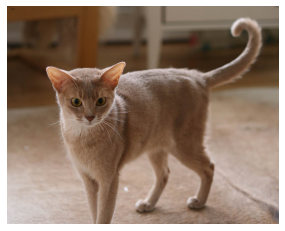

In [ ]:
img = load_img(input_img_paths[20])
plt.axis("off")
plt.imshow(img)

In [ ]:
def display_target(target_array):
  normalized_array = (target_array.astype("uint8")-1)*127
  plt.axis("off")
  plt.imshow(normalized_array[:,:,0])

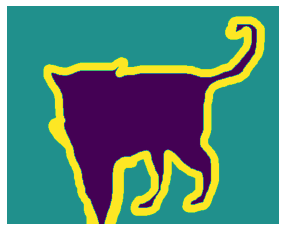

In [ ]:
img = img_to_array(load_img(target_paths[20], color_mode = "grayscale"))
display_target(img)


In [ ]:
import numpy as np
import random

img_size = (256,256)
num_imgs = len(input_img_paths)

def path_to_input_image(path):
  return img_to_array(load_img(path, target_size = img_size))

def path_to_target(path):
  img = img_to_array(load_img(path, target_size = img_size, color_mode = "grayscale"))
  img = img.astype("uint8") - 1
  return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype = "float32")

targets = np.zeros((num_imgs,) + img_size + (1,), dtype = "uint8")

for i in range(num_imgs):
  input_imgs[i] = path_to_input_image(input_img_paths[i])
  targets[i] = path_to_target(target_paths[i])

# **Spliting Dataset to Train and Test**

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(input_imgs,targets,shuffle=True,test_size=0.2)

In [ ]:
x_train=x_train /255
x_test = x_test /255

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(800, 256, 256, 3)
(800, 256, 256, 1)
(200, 256, 256, 3)
(200, 256, 256, 1)


# **U-NEt Architecture**

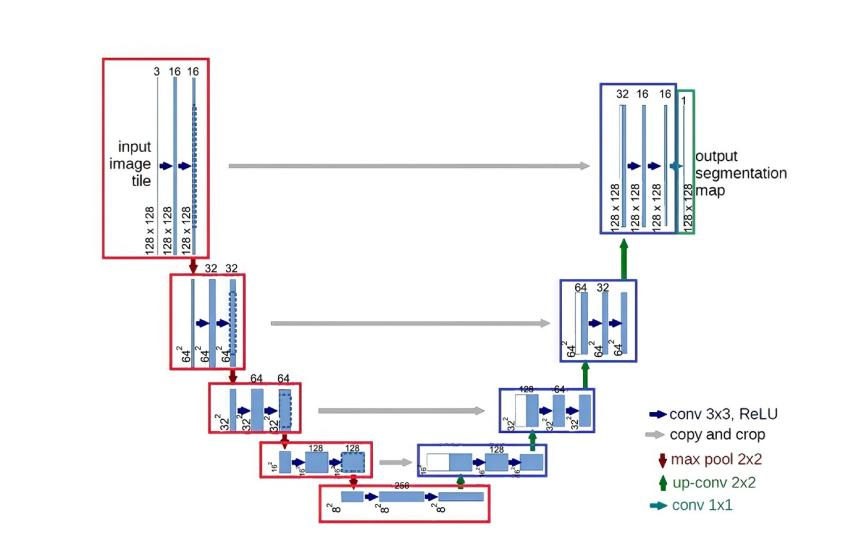

In [ ]:
inputs = Input((256, 256, 3))
#Encoding
conv_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
conv_1 = Dropout(0.1)(conv_1)
conv_1 = Conv2D(16, (3, 3), activation='relu',  padding='same')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_1)

conv_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool_1)
conv_2 = Dropout(0.1)(conv_2)
conv_2 = Conv2D(32, (3, 3), activation='relu',  padding='same')(conv_2)
pool_2 = MaxPooling2D((2, 2))(conv_2)

conv_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool_2)
conv_3 = Dropout(0.1)(conv_3)
conv_3 = Conv2D(64, (3, 3), activation='relu',  padding='same')(conv_3)
pool_3 = MaxPooling2D((2, 2))(conv_3)

conv_4 = Conv2D(128, (3, 3), activation='relu',padding='same')(pool_3)
conv_4 = Dropout(0.1)(conv_4)
conv_4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_4)
pool_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

conv_5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool_4)
conv_5 = Dropout(0.2)(conv_5)
conv_5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_5)

#Decoding
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv_5)
u6 = concatenate([u6, conv_4])
conv_6 = Conv2D(128, (3, 3), activation='relu',  padding='same')(u6)
conv_6 = Dropout(0.2)(conv_6)
conv_6 = Conv2D(128, (3, 3), activation='relu',  padding='same')(conv_6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv_6)
u7 = concatenate([u7, conv_3])
conv_7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
conv_7 = Dropout(0.1)(conv_7)
conv_7 = Conv2D(64, (3, 3), activation='relu',  padding='same')(conv_7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv_7)
u8 = concatenate([u8, conv_2])
conv_8 = Conv2D(32, (3, 3), activation='relu',  padding='same')(u8)
conv_8 = Dropout(0.2)(conv_8)
conv_8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv_8)
u9 = concatenate([u9, conv_1], axis=3)
conv_9 = Conv2D(16, (3, 3), activation='relu',  padding='same')(u9)
conv_9 = Dropout(0.1)(conv_9)
conv_9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv_9)

outputs = Conv2D(3, (1, 1), activation='softmax')(conv_9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 256, 256, 16  0           ['conv2d_38[0][0]']              
                                )                                                           

In [ ]:
model.compile(loss = "sparse_categorical_crossentropy",optimizer=tf.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
25/25 [==============================] - 8s 332ms/step - loss: 0.9154 - accuracy: 0.6015 - val_loss: 0.8867 - val_accuracy: 0.6003
Epoch 2/50
25/25 [==============================] - 8s 332ms/step - loss: 0.8680 - accuracy: 0.6015 - val_loss: 0.8331 - val_accuracy: 0.6267
Epoch 3/50
25/25 [==============================] - 8s 334ms/step - loss: 0.8149 - accuracy: 0.6397 - val_loss: 0.7763 - val_accuracy: 0.6946
Epoch 4/50
25/25 [==============================] - 8s 341ms/step - loss: 0.7646 - accuracy: 0.6878 - val_loss: 0.7503 - val_accuracy: 0.7040
Epoch 5/50
25/25 [==============================] - 8s 339ms/step - loss: 0.7354 - accuracy: 0.7118 - val_loss: 0.7182 - val_accuracy: 0.7221
Epoch 6/50
25/25 [==============================] - 9s 343ms/step - loss: 0.7244 - accuracy: 0.7153 - val_loss: 0.7089 - val_accuracy: 0.7244
Epoch 7/50
25/25 [==============================] - 9s 343ms/step - loss: 0.7261 - accuracy: 0.7117 - val_loss: 0.7759 - val_accuracy: 0.6804
Epoch 

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy*100," %")

7/7 [==============================] - 1s 88ms/step - loss: 0.6295 - accuracy: 0.8309
Test Loss: 0.6295363903045654
Test Accuracy: 83.08674097061157  %


# **Display Prediction image**

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ["Input Image", "True Mask","Predicted Mask"]
  for i in range(len(title)):
    if(i==2):
      display_list[2] = np.argmax(display_list[2], axis=-1)
      display_list[2] *= 127
      plt.subplot(1, len(display_list), i+1)
      plt.title(title[i])
      plt.imshow(display_list[2])
      plt.axis("off")

    else:
      plt.subplot(1, len(display_list), i+1)
      plt.title(title[i])
      plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
      plt.axis("off")

  plt.show()

1/1 [==============================] - 0s 30ms/step
(256, 256, 3)


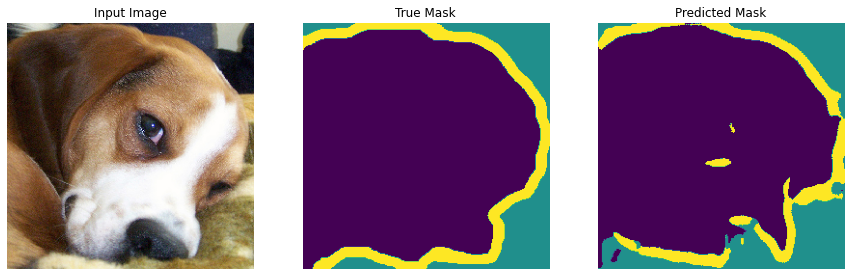

In [ ]:
mask = model.predict(np.expand_dims(x_test[5], 0))[0]
print(mask.shape)
display([x_test[5],y_test[5],mask])